<a href="https://colab.research.google.com/github/trachtok/dspracticum2020_data/blob/main/assignment07/assignment07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Natural language processing - text generator
*Kája Trachtová, Michaela Kecskésová, Martin Špilar, Dagmar Al Tukmachi*

+ goal of this assignment is to generate text based on some initial text
+ done using LSTM

## Load libraries ang input data

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = '/content/drive/My Drive/text_ML2.txt'
# !head "/content/drive/My Drive/text_ML2.txt"

Dobrý den, dámy a pánové. Vláda dnes schválila žádost Poslanecké sněmovně o vyslovení souhlasu s prodloužením nouzového stavu v souvislosti s epidemií covid-19, a to do 3. prosince 2020.
Důvodem je samozřejmě nutnost prodloužit ta přijatá krizová opatření, bez kterých stávající pandemii nemůžeme zvládnout. Takže Sněmovna projedná naši žádost v pátek od 9 hodin a já pevně doufám, že opozice pochopí vážnost situace a tuto žádost schválí. Je to, myslím si, velice důležité. Hlavně pro ochranu zdraví a životů našich spoluobčanů.
Dále jsme vzali na vědomí informaci ministra zdravotnictví ohledně antigenních testů. Pan ministr to určitě vysvětlí. Já myslím, že je to velice důležité, abychom začali urychleně toto testování, abychom hlavně ochránili naše spoluobčany nad 65 let, respektive nemocné, zdravotníky, pracovníky v sociálních službách, v domovech seniorů a další. Takže toto je dnes to klíčové, co musíme udělat.
Dále vláda vzala na vědomí záměr Ministerstva zdravotnictví realizovat kompl

In [21]:
# read input data
file = open(path, "r")
data = file.read()
print(data[:50])

Dobrý den, dámy a pánové. Vláda dnes schválila žád


## Data preprocessing

In [24]:
# if input text contains empty lines -> remove, also get rid of empty space after end of sequences
data = data.replace('\n', "").replace('. ', '.')
# split text into sequences -> get list of sequences
corpus = data.lower().split('.')
print(corpus[:5])

['dobrý den, dámy a pánové', 'vláda dnes schválila žádost poslanecké sněmovně o vyslovení souhlasu s prodloužením nouzového stavu v souvislosti s epidemií covid-19, a to do 3', 'prosince 2020', 'důvodem je samozřejmě nutnost prodloužit ta přijatá krizová opatření, bez kterých stávající pandemii nemůžeme zvládnout', 'takže sněmovna projedná naši žádost v pátek od 9 hodin a já pevně doufám, že opozice pochopí vážnost situace a tuto žádost schválí']


## Tokenization

In [6]:
# tokenize words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1
print("Total words: ", total_words)

Total words:  2064


In [29]:
# text to integers
input_sequences = []
for line in corpus:
  token_list = tokenizer.texts_to_sequences([line])[0]
  for i in range(1, len(token_list)):
    n_gram_sequence = token_list[:i + 1]
    input_sequences.append(n_gram_sequence)
print(input_sequences[1:10])

[[70, 64, 108], [70, 64, 108, 1], [70, 64, 108, 1, 109], [17, 33], [17, 33, 440], [17, 33, 440, 192], [17, 33, 440, 192, 317], [17, 33, 440, 192, 317, 441], [17, 33, 440, 192, 317, 441, 9]]


In [31]:
# padding
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen = max_sequence_len, padding = 'pre'))
print(input_sequences[1:5])
print(max_sequence_len)

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0  70  64 108]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0  70  64 108   1]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0 

## Model training

In [12]:
# create predictors and label
xs = input_sequences[:, :-1]
labels = input_sequences[:, -1]
ys = tf.keras.utils.to_categorical(labels, num_classes = total_words)

In [13]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150)))
model.add(Dense(total_words, activation='softmax'))
adam = Adam(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history = model.fit(xs, ys, epochs=50, verbose=1)
print(model)

Epoch 1/50
192/192 [==============================] - 4s 20ms/step - loss: 7.1096 - accuracy: 0.0394
Epoch 2/50
192/192 [==============================] - 4s 20ms/step - loss: 6.1875 - accuracy: 0.0772
Epoch 3/50
192/192 [==============================] - 4s 20ms/step - loss: 5.1823 - accuracy: 0.1328
Epoch 4/50
192/192 [==============================] - 4s 20ms/step - loss: 3.9578 - accuracy: 0.2212
Epoch 5/50
192/192 [==============================] - 4s 20ms/step - loss: 2.6643 - accuracy: 0.3980
Epoch 6/50
192/192 [==============================] - 4s 20ms/step - loss: 1.7088 - accuracy: 0.5909
Epoch 7/50
192/192 [==============================] - 4s 20ms/step - loss: 1.1173 - accuracy: 0.7226
Epoch 8/50
192/192 [==============================] - 4s 20ms/step - loss: 0.7531 - accuracy: 0.8139
Epoch 9/50
192/192 [==============================] - 4s 20ms/step - loss: 0.5222 - accuracy: 0.8740
Epoch 10/50
192/192 [==============================] - 4s 20ms/step - loss: 0.3870 - accura

In [16]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

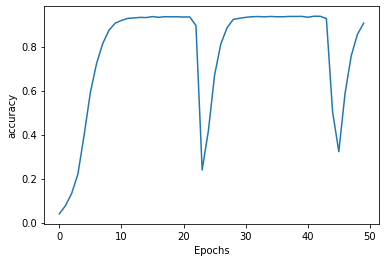

In [17]:
plot_graphs(history, 'accuracy')


In [19]:
seed_text = "Dámy a pánové"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

Dámy a pánové je to donutí aby se začali chovat trochu s ohledem na ostatní čr a skutečně na to složité a třetí nakupovat připraven a určitě budeme potřeba nakupovat těchto léčivých přípravků do 25 zemí a pokud to uděláme samozřejmě potřeba nakupovat těchto a že to i když jsme dnes přijali společně důležité jsem tu situaci vážně a znovu vás žádám prosím vás pravidla zase samozřejmě nejvíce ohroženi a proto máme o ně samozřejmě velkou starost tak jsme rozhodli že vláda zakazuje taky dnes od půlnoci všem osobám přítomnost v maloobchodních prodejnách potravin v čase od 10 hodin do 12 hodin a
